In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# GPU kontrolü
print("📌 GPU:", tf.config.list_physical_devices('GPU'))


2025-06-27 16:34:36.819577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751042076.987985      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751042077.033738      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📌 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DICOM_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
LABELS_PATH = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
PNG_DIR = "/kaggle/working/rsna_png"
os.makedirs(PNG_DIR, exist_ok=True)

df = pd.read_csv(LABELS_PATH).drop_duplicates('patientId')
for pid in tqdm(df['patientId'].values):
    dcm_path = os.path.join(DICOM_DIR, pid + ".dcm")
    png_path = os.path.join(PNG_DIR, pid + ".png")

    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
    img = cv2.resize(img.astype(np.uint8), (224, 224))
    cv2.imwrite(png_path, img)


100%|██████████| 26684/26684 [08:58<00:00, 49.58it/s]  


In [4]:
df['filename'] = df['patientId'] + ".png"
df['Target'] = df['Target'].astype(str)

train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Target'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['Target'], random_state=42)

print("Eğitim:", len(train_df), "Doğrulama:", len(val_df), "Test:", len(test_df))


Eğitim: 19212 Doğrulama: 2135 Test: 5337


In [5]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['Target']), y=train_df['Target'])
class_weights = dict(zip(np.unique(train_df['Target']), weights))
print("Class Weights:", class_weights)


Class Weights: {'0': 0.6454343882281798, '1': 2.218988218988219}


In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, PNG_DIR,
                                              x_col='filename', y_col='Target',
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE)

val_gen = val_test_datagen.flow_from_dataframe(val_df, PNG_DIR,
                                               x_col='filename', y_col='Target',
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

test_gen = val_test_datagen.flow_from_dataframe(test_df, PNG_DIR,
                                                x_col='filename', y_col='Target',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)


Found 19212 validated image filenames belonging to 2 classes.
Found 2135 validated image filenames belonging to 2 classes.
Found 5337 validated image filenames belonging to 2 classes.


In [7]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # İlk başta donmuş katmanlar

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1751042626.946287      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
callbacks = [
    ModelCheckpoint("best_resnet_model.h5", save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    class_weight=class_weights,
                    callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751042641.282543     100 service.cc:148] XLA service 0x7cf738003ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751042641.283424     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751042642.853498     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/601 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.5625 - loss: 1.0263   

I0000 00:00:1751042647.246372     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7809 - loss: 0.4876
Epoch 1: val_loss improved from inf to 0.39299, saving model to best_resnet_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 227s 350ms/step - accuracy: 0.7809 - loss: 0.4875 - val_accuracy: 0.8192 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 2/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8046 - loss: 0.4241
Epoch 2: val_loss improved from 0.39299 to 0.39130, saving model to best_resnet_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 199s 331ms/step - accuracy: 0.8046 - loss: 0.4240 - val_accuracy: 0.8108 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 3/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8098 - loss: 0.4096
Epoch 3: val_loss improved from 0.39130 to 0.38655, saving model to best_resnet_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 195s 325ms/step - accuracy: 0.8098 - loss: 0.4096 - val_accuracy: 0.8169 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 4/20
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/

In [9]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_history = model.fit(train_gen,
                         validation_data=val_gen,
                         epochs=10,
                         class_weight=class_weights,
                         callbacks=callbacks)


Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8139 - loss: 0.4203
Epoch 1: val_loss improved from 0.38130 to 0.38022, saving model to best_resnet_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 243s 354ms/step - accuracy: 0.8139 - loss: 0.4202 - val_accuracy: 0.8117 - val_loss: 0.3802 - learning_rate: 1.0000e-05
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8269 - loss: 0.3873
Epoch 2: val_loss improved from 0.38022 to 0.36570, saving model to best_resnet_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 197s 328ms/step - accuracy: 0.8269 - loss: 0.3873 - val_accuracy: 0.8220 - val_loss: 0.3657 - learning_rate: 1.0000e-05
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8282 - loss: 0.3804
Epoch 3: val_loss did not improve from 0.36570
601/601 ━━━━━━━━━━━━━━━━━━━━ 194s 323ms/step - accuracy: 0.8283 - loss: 0.3804 - val_accuracy: 0.8290 - val_loss: 0.3719 - learning_rate: 1.0000e-05
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy

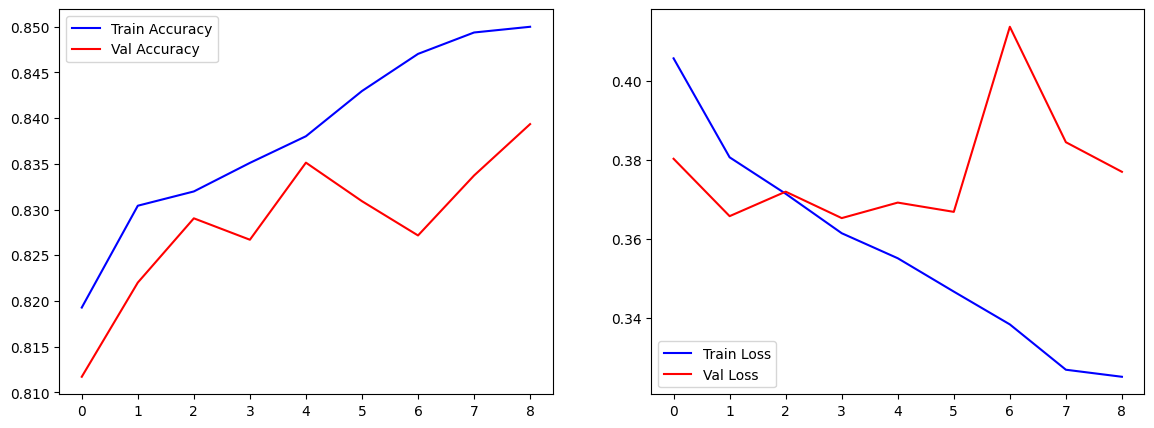

In [10]:
def plot_training(h):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.legend()

    plt.show()

plot_training(fine_history)


167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step
ROC AUC: 0.8691911103420941
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4135
           1       0.76      0.34      0.47      1202

    accuracy                           0.83      5337
   macro avg       0.80      0.66      0.68      5337
weighted avg       0.82      0.83      0.80      5337



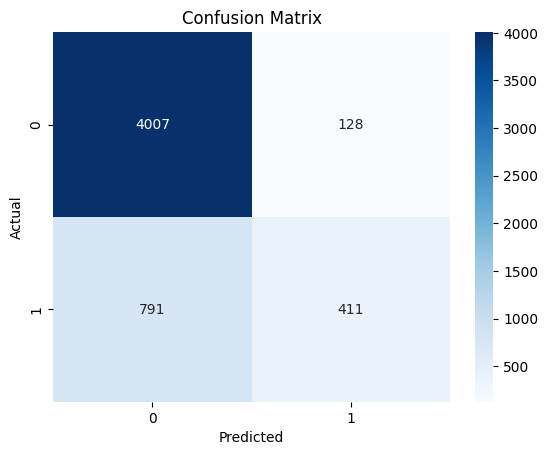

In [11]:
model.load_weights("best_resnet_model.h5")  # En iyi model yüklendi

y_true = test_gen.classes
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
